In [1]:
## https://github.com/clbonet/Hyperbolic_Sliced-Wasserstein_via_Geodesic_and_Horospherical_Projections

import torch
import ot
import math
import sys

import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from itertools import cycle
from tqdm.auto import trange
from mpl_toolkits import mplot3d
from scipy.stats import gaussian_kde
from typing import Any, Tuple, Optional
from torch import Tensor
from copy import deepcopy

import sys
sys.path.append('../lib')

from utils_hyperbolic import *
from distributions import sampleWrappedNormal
from hsw import hyper_sliced_wasserstein
from hhsw import horo_hyper_sliced_wasserstein_poincare, horo_hyper_sliced_wasserstein_lorentz
from sw import sliced_wasserstein
from utility import *

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [19]:
eps = 1e-7
max_clamp_norm = 40
max_norm = 85
ln_2: torch.Tensor = math.log(2)

radius = torch.Tensor([1.0]).to(device)


def expand_proj_dims(x: torch.Tensor) -> torch.Tensor:
    zeros = torch.zeros(x.shape[:-1] + torch.Size([1])).to(x.device).to(x.dtype)
    return torch.cat((zeros, x), dim=-1)

# We will use this clamping technique to ensure numerical stability of the Exp and Log maps
class LeakyClamp(torch.autograd.Function):
    @staticmethod
    def forward(ctx: Any, x: torch.Tensor, min: float, max: float) -> torch.Tensor:
        ctx.save_for_backward(x.ge(min) * x.le(max))
        return torch.clamp(x, min=min, max=max)

    @staticmethod
    def backward(ctx: Any, grad_output: torch.Tensor) -> Tuple[torch.Tensor, None, None]:
        mask, = ctx.saved_tensors
        mask = mask.type_as(grad_output)
        return grad_output * mask + grad_output * (1 - mask) * eps, None, None

def clamp(x: torch.Tensor, min: float = float("-inf"), max: float = float("+inf")) -> torch.Tensor:
    return LeakyClamp.apply(x, min, max)

def cosh(x: torch.Tensor) -> torch.Tensor:
    x = clamp(x, min=-max_norm, max=max_norm)
    return torch.cosh(x)

def sinh(x: torch.Tensor) -> torch.Tensor:
    x = clamp(x, min=-max_norm, max=max_norm)
    return torch.sinh(x)

# Exp map for the origin has a special form which doesn't need the Lorentz norm
def exp_map_mu0(x: Tensor, radius: Tensor) -> Tensor:
    assert x[..., 0].allclose(torch.zeros_like(x[..., 0]))
    x = x[..., 1:]
    x_norm = torch.norm(x, p=2, keepdim=True, dim=-1) / radius
    x_normed = F.normalize(x, p=2, dim=-1) * radius
    ret = torch.cat((cosh(x_norm) * radius, sinh(x_norm) * x_normed), dim=-1)
    assert torch.isfinite(ret).all()
    return ret

# Helper function to do the plotting
def plot_density(xy_poincare, probs, radius, mu=None, ax=None):
    axis_lim = 1.03
    
    if ax is None:
        fig = plt.figure(figsize=(9,9))
        ax = fig.add_subplot(111)

    x = xy_poincare[:, 0].view(-1, 100).detach().cpu()
    y = xy_poincare[:, 1].view(-1, 100).detach().cpu()
    z = probs.view(-1, 100).detach().cpu()
    range_lim = 2
    # Define points within circle
    if mu is not None:
        mu = mu.cpu().numpy()
        plt.plot(mu[:, 0], mu[:, 1], 'b+')

    cnt = ax.contourf(x, y, z, 100, antialiased=False)
    
    for c in cnt.collections:
        c.set_edgecolor("face")
    ax.axis('off')

    # draw some fancy circle
    circle = plt.Circle((0, 0), 1, color='k', linewidth=2, fill=False)
    ax.add_patch(circle)
    # Makes the circle look like a circle
    ax.axis('equal')
    ax.set_xlim(-axis_lim, axis_lim)
    ax.set_ylim(-axis_lim, axis_lim)


def plot_distrib(X, ax, h=None):
    kernel = gaussian_kde(X.detach().cpu().numpy().T)
    
    if h is not None:
        kernel.set_bandwidth(h)

    # Map x, y coordinates on tangent space at origin to manifold (Lorentz model).
    x = np.arange(-5, 5, 0.1)
    y = np.arange(-5, 5, 0.1)
    x, y = np.meshgrid(x, y)
    x = torch.Tensor(x).view(-1, 1)
    y = torch.Tensor(y).view(-1, 1)
    twodim = torch.cat([x, y], dim=1)
    threedim = expand_proj_dims(twodim)
    clamped_threedim = clamp(threedim, min=-max_clamp_norm,
          max=max_clamp_norm).to(device)

    on_mani = exp_map_mu0(clamped_threedim, radius)
    probs = torch.tensor(kernel.pdf(on_mani.T.detach().cpu().numpy()))
    # Calculate the poincare coordinates
    xy_poincare = lorentz_to_poincare(on_mani.squeeze(), radius)
    plot_density(xy_poincare, probs, radius,ax=ax)


def plot_fig(X_target, L_hsw, L_hhsw, L_swp, L_sw, L_sfw, ax0, ax1, h=None, skip=50,  
             xlabels=True, ylabels=True, xticks=True, yticks=True, title=False, legend=False, ax0_legend=False):
    L_hsw10 = np.log10(L_hsw)
    L_hhsw10 = np.log10(L_hhsw)
    L_swp10 = np.log10(L_swp)
    L_sw10 = np.log10(L_sw[np.where(L_sw[:,-1]>0)[0],:])
    # L_sw10 = np.log10(L_sw)
    L_sfw10 = np.log10(L_sfw)

    mean_hsw = np.mean(L_hsw10, axis=0)
    std_hsw = np.std(L_hsw10, axis=0)

    mean_hhsw = np.mean(L_hhsw10, axis=0)
    std_hhsw = np.std(L_hhsw10, axis=0)

    mean_swp = np.mean(L_swp10, axis=0)
    std_swp = np.std(L_swp10, axis=0)

    mean_sw = np.mean(L_sw10, axis=0)
    std_sw = np.std(L_sw10, axis=0)

    mean_sfw = np.mean(L_sfw10, axis=0)
    std_sfw = np.std(L_sfw10, axis=0)

    n_epochs = len(mean_hhsw)
    iterations = range(n_epochs)
    
    plot_distrib(X_target, ax0, h)
    if ax0_legend:
        ax0.set_title(r"Target distributions", va='bottom', fontsize=13)
        
    ax1.plot(iterations[::skip], mean_hsw[::skip], label="GHSW", c="lightgreen")
    ax1.fill_between(iterations[::skip], mean_hsw[::skip]-std_hsw[::skip], mean_hsw[::skip]+std_hsw[::skip], alpha=0.5, facecolor="lightgreen")
    ax1.plot(iterations[::skip], mean_hhsw[::skip], label="HHSW", c="g")
    ax1.fill_between(iterations[::skip], mean_hhsw[::skip]-std_hhsw[::skip], mean_hhsw[::skip]+std_hhsw[::skip], alpha=0.5, facecolor="g")
    ax1.plot(iterations[::skip], mean_swp[::skip], label=r"SW$_\mathbb{B}$", c="c")
    ax1.fill_between(iterations[::skip], mean_swp[::skip]-std_swp[::skip], mean_swp[::skip]+std_swp[::skip], alpha=0.5, facecolor="c")
    ax1.plot(iterations[::skip], mean_sw[::skip], label=r"SW$_\mathbb{L}$", c="b")
    ax1.fill_between(iterations[::skip], mean_sw[::skip]-std_sw[::skip], mean_sw[::skip]+std_sw[::skip], alpha=0.5, facecolor="b")
    ax1.plot(iterations[::skip], mean_sfw[::skip], label="SFW", c="r")
    ax1.fill_between(iterations[::skip], mean_sfw[::skip]-std_sfw[::skip], mean_sfw[::skip]+std_sfw[::skip], alpha=0.5, facecolor="r")

    if xlabels:
        ax1.set_xlabel("Iterations", fontsize=13)
        
    if title:
        ax1.set_title(r"$\log_{10}(W_2^2(\hat{\mu}_t,\nu))$", fontsize=13)
        
    ax1.grid(True)
    
    if not xticks:
        ax1.xaxis.set_ticklabels([])
    if legend:
        ax1.legend()



In [25]:
L_hsw_wnd_c = np.loadtxt("./Results/hsw_loss_wnd_center")
L_hhsw_wnd_c = np.loadtxt("./Results/hhsw_loss_wnd_center")
L_swp_wnd_c = np.loadtxt("./Results/swp_loss_wnd_center")
L_sw_wnd_c = np.loadtxt("./Results/sw_loss_wnd_center")
L_sfw_wnd_c = np.loadtxt("./Results/sfw_loss_wnd_center")


L_hsw_wnd_b = np.loadtxt("./Results/hsw_loss_wnd_border")
L_hhsw_wnd_b = np.loadtxt("./Results/hhsw_loss_wnd_border")
L_swp_wnd_b = np.loadtxt("./Results/swp_loss_wnd_border")
L_sw_wnd_b = np.loadtxt("./Results/sw_loss_wnd_border")
L_sfw_wnd_b = np.loadtxt("./Results/sfw_loss_wnd_border")



L_hsw_mwnd_c = np.loadtxt("./Results/hsw_loss_mwnd_center")
L_hhsw_mwnd_c = np.loadtxt("./Results/hhsw_loss_mwnd_center")
L_swp_mwnd_c = np.loadtxt("./Results/swp_loss_mwnd_center")
L_sw_mwnd_c = np.loadtxt("./Results/sw_loss_mwnd_center")
L_sfw_mwnd_c = np.loadtxt("./Results/sfw_loss_mwnd_center")


L_hsw_mwnd_b = np.loadtxt("./Results/hsw_loss_mwnd_border")
L_hhsw_mwnd_b = np.loadtxt("./Results/hhsw_loss_mwnd_border")
L_swp_mwnd_b = np.loadtxt("./Results/swp_loss_mwnd_border")
L_sw_mwnd_b = np.loadtxt("./Results/sw_loss_mwnd_border")
L_sfw_mwnd_b = np.loadtxt("./Results/sfw_loss_mwnd_border")


In [26]:
mu = torch.tensor([1.5, np.sqrt(1.5**2-1), 0], dtype=torch.float64, device=device)
Sigma = 0.1 * torch.tensor([[1,0],[0,1]], dtype=torch.float, device=device)
X_target_wnd_c = sampleWrappedNormal(mu, Sigma, 10000)



mu = torch.tensor([8, np.sqrt(63), 0], dtype=torch.float64, device=device)
Sigma = 0.1 * torch.tensor([[1,0],[0,1]], dtype=torch.float, device=device)
X_target_wnd_b = sampleWrappedNormal(mu, Sigma, 10000)



ps = np.ones(5)/5
mus_lorentz = torch.tensor([[0,0.5],[0.5,0],[0,-0.5],[-0.5,0], [0,0.1]], dtype=torch.float)
mus = poincare_to_lorentz(mus_lorentz)
sigma = 0.01 * torch.tensor([[1,0],[0,1]], dtype=torch.float)

Z = np.random.multinomial(10000, ps)
X = []
for l in range(len(Z)):
    if Z[l]>0:
        samples = sampleWrappedNormal(mus[l], sigma, int(Z[l])).numpy()
        X += list(samples)

X_target_mwnd_c = torch.tensor(X, device=device, dtype=torch.float)



ps = np.ones(5)/5
mus_lorentz = torch.tensor([[0,0.9],[0.9,0],[0,-0.9],[-0.9,0], [0,0.1]], dtype=torch.float)
mus = poincare_to_lorentz(mus_lorentz)
sigma = 0.01 * torch.tensor([[1,0],[0,1]], dtype=torch.float)

Z = np.random.multinomial(10000, ps)
X = []
for l in range(len(Z)):
    if Z[l]>0:
        samples = sampleWrappedNormal(mus[l], sigma, int(Z[l])).numpy()
        X += list(samples)

X_target_mwnd_b = torch.tensor(X, device=device, dtype=torch.float)

/usr/local/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/usr/local/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/usr/local/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:251: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


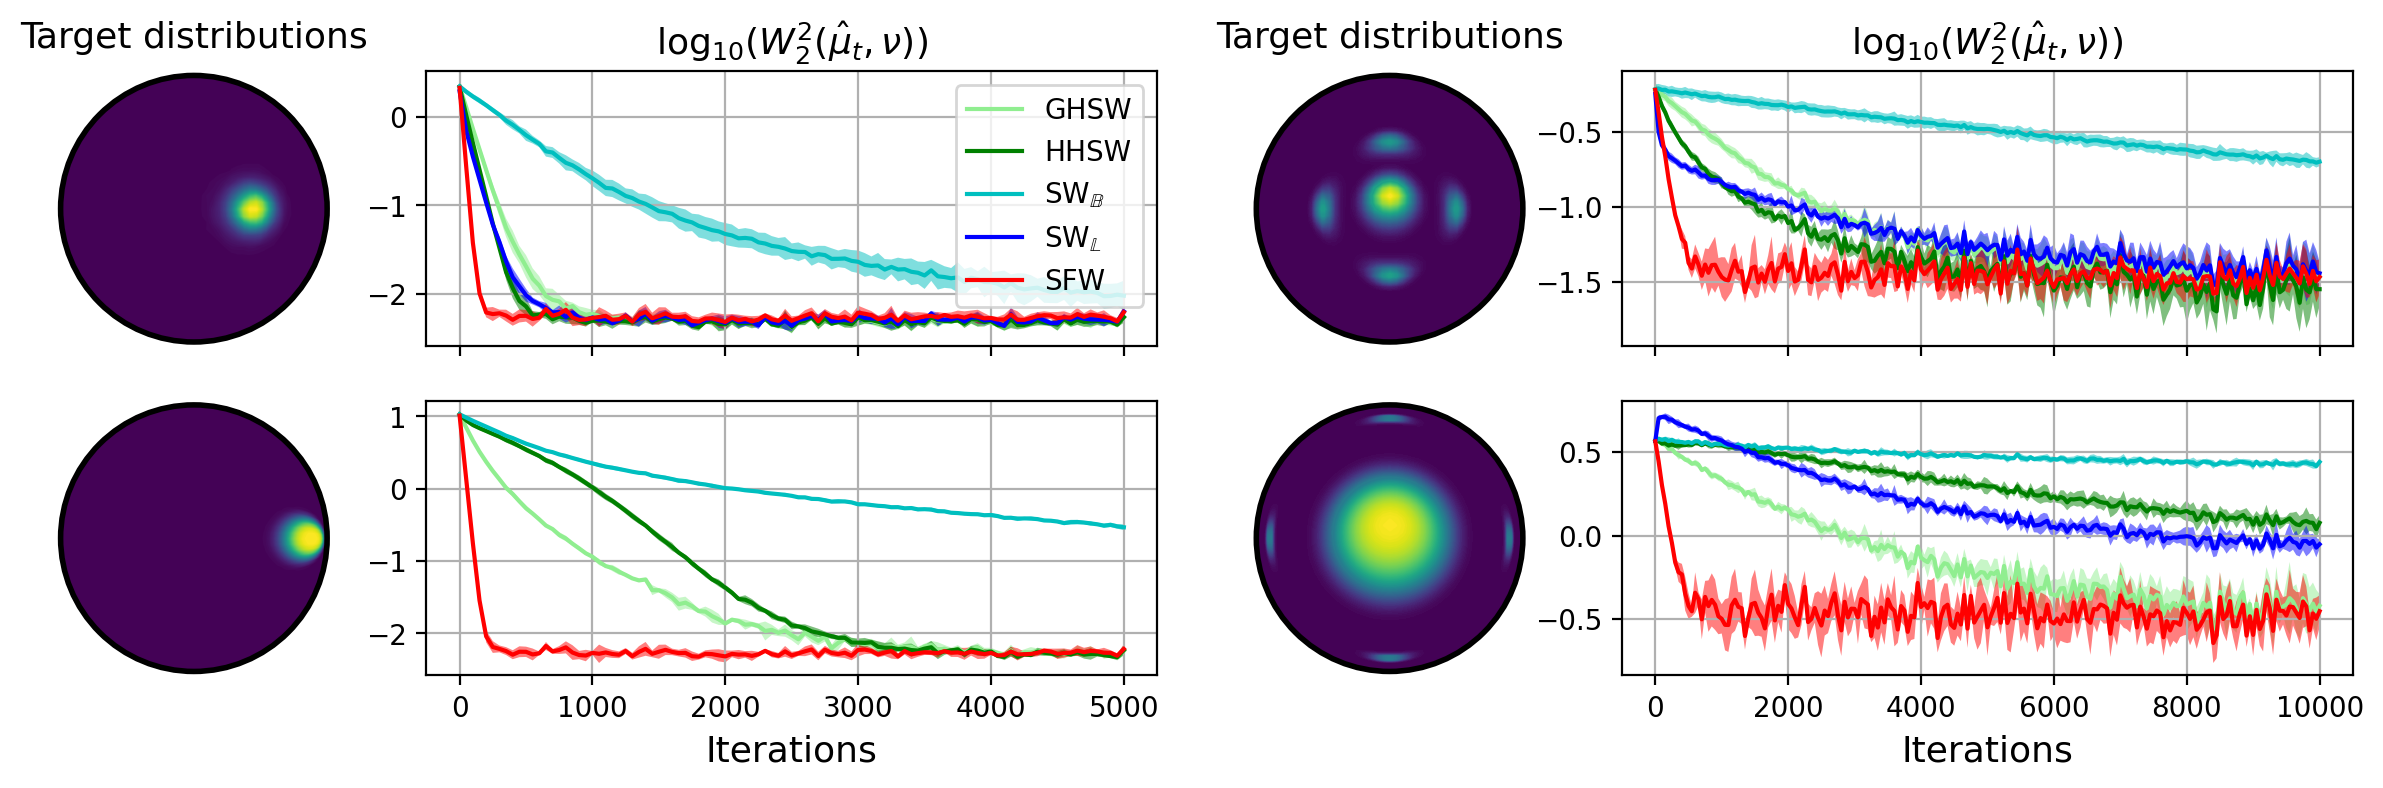

In [27]:
import matplotlib.font_manager

plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.serif": "cm"
})

plt.subplots(2, 6, figsize=(15,4), dpi=200)

ax1 = plt.subplot(2, 6, 1)
ax11 = plt.subplot(2, 6, (2, 3))

plot_fig(X_target_wnd_c, L_hsw_wnd_c, L_hhsw_wnd_c, L_swp_wnd_c, L_sw_wnd_c, L_sfw_wnd_c, ax1, ax11, 
         xticks=False, xlabels=False, title=True,legend=True, ax0_legend=True)

ax2 = plt.subplot(2, 6, 7)
ax22 = plt.subplot(2, 6, (8, 9))

plot_fig(X_target_wnd_b, L_hsw_wnd_b, L_hhsw_wnd_b, L_swp_wnd_b, L_sw_wnd_b, L_sfw_wnd_b, ax2, ax22, h=5)

ax3 = plt.subplot(2, 6, 4)
ax33 = plt.subplot(2, 6, (5, 6))

plot_fig(X_target_mwnd_c, L_hsw_mwnd_c, L_hhsw_mwnd_c, L_swp_mwnd_c, L_sw_mwnd_c, L_sfw_mwnd_c, ax3, ax33, 
         xticks=False, xlabels=False, title=True, ax0_legend=True)

ax4 = plt.subplot(2, 6, 10)
ax44 = plt.subplot(2, 6, (11, 12))

plot_fig(X_target_mwnd_b, L_hsw_mwnd_b, L_hhsw_mwnd_b, L_swp_mwnd_b, L_sw_mwnd_b, L_sfw_mwnd_b, ax4, ax44, 
         h=0.15)


plt.show()